# Analyzing the Mercari children's book dataset

## Import libraries and files

In [1]:
%matplotlib notebook
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split

os.chdir('/Users/mleong/github/used-books')
books = pd.read_csv('used-book-data.csv')



### Feature Engineering

In [2]:
# eliminate duplicate rows
books = books.drop_duplicates()

# id: convert to string
books.id = books.id.astype(str)

# posted: convert to datetime
books.posted = pd.to_datetime(books.posted)

# sold: combine buy now and add to cart categories to be 'for sale'
books = books.replace('Buy now', 'available')

# price: modify to eliminate '$' sign and convert to number
books['price'] = books['price'].str.replace(',', '')
books['price'] = books['price'].str.replace('$', '')
books['price'] = books['price'].astype(int)

# create new column "shipping_cost" that is continuous variable from $0 to whatever shipping fee is
def shipping_cost(shipping_string):
    shipping_after = shipping_string.split(" | ")
    if 'Free' in shipping_after[0]:
        shipping_cost = 0
    elif '$' in shipping_after[0]:
        shipping_cost = shipping_after[0]
        shipping_cost = shipping_cost.replace('$', '') 
    else:
        shipping_cost = None
    return shipping_cost
books['shipping_cost'] = books['shipping'].apply(shipping_cost)
books.shipping_cost = pd.to_numeric(books.shipping_cost, errors='coerce')

# create new simpler column "shipping_time" that is number of days to arrival
def shipping_time(shipping_string):
    if 'days' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'days' in shipping_after[0]:
            shipping_time = shipping_after[0]
            shipping_time = shipping_time.replace('+ days', '')
        elif 'days' in shipping_after[1]:
            shipping_time = shipping_after[1]
            shipping_time = shipping_time.replace('+ days', '')
        else:
            shipping_time = None
    else:
        shipping_time = None
    return shipping_time
books['shipping_time'] = books['shipping'].apply(shipping_time)

# create new simpler column "shipping_location" that is just the state product is coming from
def shipping_location(shipping_string):
    if 'from' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'from' in shipping_after[0]:
            shipping_location = shipping_after[0]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[1]:
            shipping_location = shipping_after[1]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[2]:
            shipping_location = shipping_after[2]
            shipping_location = shipping_location.replace('from ', '')
        else:
            shipping_location = None
    else:
        shipping_location = None
    return shipping_location
books['shipping_location'] = books['shipping'].apply(shipping_location)

# total price: new column that is sum of price and shipping fee
books['total_price'] = books['price']+books['shipping_cost']

# Making free_shipping column a yes/no
def free_shipping(shipping_cost):
    if shipping_cost == 0:
        free_shipping = 1
    else:
        free_shipping = 0
    return free_shipping
books['free_shipping'] = books.shipping_cost.apply(free_shipping)

# Making brand_included feature thats just a yes or no
books['brand_included'] = books.brand.notnull()
zeroANDones = lambda x: x*1
books.brand_included = books.brand_included.apply(zeroANDones)

# New column sold_true
def sold_true(status):
    if status == 'SOLD':
        sold_true = 1
    else:
        sold_true = 0
    return sold_true
books['sold_true'] = books.sold.apply(sold_true)

# New column summing of description length
def description_length(desc_string):
    description_length = len(desc_string)
    return description_length
books['description_length'] = books.description.apply(description_length)

# New column summing of title length
def title_length(title_string):
    title_length = len(title_string)
    return title_length
books['title_length'] = books.title.apply(title_length)

# New column condition_ordinal from new = 1, like new = 2, good = 3, fair = 4, poor = 5
def condition_ordinal(condition):
    if condition == "New":
        condition_ordinal = 1
    elif condition == "Like new":
        condition_ordinal = 2
    elif condition == "Good":
        condition_ordinal = 3
    elif condition == "Fair":
        condition_ordinal = 4
    elif condition == "Poor":
        condition_ordinal = 5
    else: condition_ordinal = None
    return condition_ordinal
books['condition_ordinal'] = books.condition.apply(condition_ordinal)

# New column days_since_posted. Was scraped on 2019-06-10 so range from 0 and up.
from datetime import date

def days_since_posted(posted):
    posted_day = date(posted.year, posted.month, posted.day)
    scrape_day = date(2019, 6, 10)
    days_since_posted = scrape_day - posted_day
    return days_since_posted.days
books['days_since_posted'] = books.posted.apply(days_since_posted)




In [3]:
# award winning people
geiselpeople = pd.read_csv('geiselpeople2.csv', encoding = "ISO-8859-1")
geiselpeople = geiselpeople.drop_duplicates()
geiselpeoplelist = geiselpeople['people'].tolist()

# amazon bestsellers
amazon = pd.read_csv('amazon.csv')
amazon = amazon.drop_duplicates()
amazonlist = amazon['amazon'].tolist()

# popular brands
popularbrands = ['disney','pixar', 'frozen', 'moana', 'toy story',
                 'americangirl', 'american girl',
                 'dr seuss', 'dr. seuss', 'drseuss', 'dr.seuss',
                 'lego', 'sesame street', 'sesamestreet', 'elmo', 'cookie monster', 'big bird',
                 'leap frog', 'leapfrog', 'minecraft', 'mine craft', 'marvel',
                 'spider-man', 'spiderman', 'hulk', 'iron man', 'thor', 'captain america',
                 'wolverine', 'black panther', 'doctor strange', 'captain marvel', 'black widow',
                 'scarlet witch', 'hawkeye', 'daredevil', 'silver surfer', 'avengers', 'xmen',
                 'x-men', 'deadpool', 'eric carle', 'hungry caterpillar', 'ericcarle', 
                 'nickelodean', 'starwars', 'star wars', 'jedi', 'yoda', 'darth vader', 
                 'winnie-the-pooh', 'winnie the pooh', 'tigger', 'eeyore', 
                 'harrypotter', 'harry potter', 'hogwarts', 'dumbledore', 'fanstastic beasts',
                 'diary of a wimpy kid', 'wimpy kid'
                ]
# Creating megastring!
def megastring(row):
  return (str(row['brand']) + " " + str(row['title']) + " " + str(row['description'])).lower()

books['megastring'] = books.apply(megastring, axis = 1)

def geiselpeople(megastring):
    """The Theodor Seuss Geisel Award is a literary award 
    by the American Library Association (ALA) that annually 
    recognizes the "author(s) and illustrator(s) of the most 
    distinguished book for beginning readers published in 
    English in the United States during the preceding year.
    All winning and nomineed authors/illustrators listed here
    """
    megalist = geiselpeoplelist
    megalist = [x.lower() for x in megalist]
    if any(word in megastring for word in megalist):
        return(1)
    else:
        return(0)
books['awardees'] = books.megastring.apply(geiselpeople)

def amazon(megastring):
    """amazon children's books best sellers list as of 18June2019.
    Kind of biased towards father's day, summer holiday travel,
    and summer holiday school work though
    """
    megalist = amazonlist
    megalist = [x.lower() for x in megalist]
    if any(word in megastring for word in megalist):
        return(1)
    else:
        return(0)
books['amazon'] = books.megastring.apply(amazon)

def topbrands(megastring):
    """the most frequently listed mercari brands
    and key words
    """
    megalist = popularbrands
    megalist = [x.lower() for x in megalist]
    if any(word in megastring for word in megalist):
        return(1)
    else:
        return(0)
books['topbrands'] = books.megastring.apply(topbrands)

# Feature engineering like what
def disney(megastring):
    if any(word in megastring for word in ['disney','pixar', 'frozen', 'moana', 'toy story' ]): 
        return(1)
    else:
        return(0)
books['disney'] = books.megastring.apply(disney)

def americangirl(megastring):
    if any(word in megastring for word in ['americangirl', 'american girl']): 
        return(1)
    else:
        return(0)
books['americangirl'] = books.megastring.apply(americangirl)

def seuss(megastring):
    if any(word in megastring for word in ['dr seuss', 'dr. seuss', 'drseuss', 'dr.seuss']): 
        return(1)
    else:
        return(0)
books['seuss'] = books.megastring.apply(seuss)

def lego(megastring):
    if any(word in megastring for word in ['lego']): 
        return(1)
    else:
        return(0)
books['lego'] = books.megastring.apply(lego)

def sesame(megastring):
    if any(word in megastring for word in ['sesame street', 'sesamestreet', 'elmo', 'cookie monster', 'big bird']): 
        return(1)
    else:
        return(0)
books['sesame'] = books.megastring.apply(sesame)

def leapfrog(megastring):
    if any(word in megastring for word in ['leap frog', 'leapfrog']): 
        return(1)
    else:
        return(0)
books['leapfrog'] = books.megastring.apply(leapfrog)

def minecraft(megastring):
    if any(word in megastring for word in ['minecraft', 'mine craft']): 
        return(1)
    else:
        return(0)
books['minecraft'] = books.megastring.apply(minecraft)

def marvel(megastring):
    if any(word in megastring for word in ['spider-man', 'spiderman', 'hulk', 'iron man', 'thor', 'captain america',
                                           'wolverine', 'black panther', 'doctor strange', 'captain marvel', 'black widow',
                                           'scarlet witch', 'hawkeye', 'daredevil', 'silver surfer', 'avengers', 'xmen',
                                           'x-men', 'deadpool']):
        return(1)
    else:
        return(0)
books['marvel'] = books.megastring.apply(marvel)
           
def ericcarle(megastring):
    if any(word in megastring for word in ['eric carle', 'hungry caterpillar', 'ericcarle']):
        return(1)
    else:
        return(0)
books['ericcarle'] = books.megastring.apply(ericcarle)
           
def nickelodean(megastring):
    if any(word in megastring for word in ['nickelodean']):
        return(1)
    else:
        return(0)
books['nickelodean'] = books.megastring.apply(nickelodean)

def starwars(megastring):
    if any(word in megastring for word in ['starwars', 'star wars', 'jedi', 'yoda', 'darth vader']):
        return(1)
    else:
        return(0)
books['starwars'] = books.megastring.apply(starwars)

def winniethepooh(megastring):
    if any(word in megastring for word in ['winnie-the-pooh', 'winnie the pooh', 'tigger', 'eeyore']):
        return(1)
    else:
        return(0)
books['winniethepooh'] = books.megastring.apply(winniethepooh)

def harrypotter(megastring):
    if any(word in megastring for word in ['harrypotter', 'harry potter', 'hogwarts', 'dumbledore', 'fanstastic beasts']):
        return(1)
    else:
        return(0)
books['harrypotter'] = books.megastring.apply(harrypotter)

def wimpykid(megastring):
    if any(word in megastring for word in ['diary of a wimpy kid', 'wimpy kid']):
        return(1)
    else:
        return(0)
books['wimpykid'] = books.megastring.apply(wimpykid)

def wimpykid(megastring):
    if any(word in megastring for word in ['diary of a wimpy kid', 'wimpy kid']):
        return(1)
    else:
        return(0)
books['wimpykid'] = books.megastring.apply(wimpykid)

def fisherprice(megastring):
    if any(word in megastring for word in ['fisherprice', 'fisher-price', 'fisher price']):
        return(1)
    else:
        return(0)
books['fisherprice'] = books.megastring.apply(fisherprice)

def scholastic(megastring):
    if any(word in megastring for word in ['scholastic']):
        return(1)
    else:
        return(0)
books['scholastic'] = books.megastring.apply(scholastic)

def bundle(megastring):
    if any(word in megastring for word in ['bundle', 'set of']):
        return(1)
    else:
        return(0)
books['bundle'] = books.megastring.apply(bundle)

def vintage(megastring):
    if any(word in megastring for word in ['vintage']):
        return(1)
    else:
        return(0)
books['vintage'] = books.megastring.apply(vintage)

def smokefree(megastring):
    if any(word in megastring for word in ['smokefree', 'smoke free', 'smoke-free', 'pet free', 'pet-free', 'petfree']):
        return(1)
    else:
        return(0)
books['smokefree'] = books.megastring.apply(smokefree)

def hardcover(megastring):
    if any(word in megastring for word in ['hard cover', 'hardcover', 'hard-cover']):
        return(1)
    else:
        return(0)
books['hardcover'] = books.megastring.apply(hardcover)



In [4]:
books_subset = books_filtered = books[(books.total_price <= 60) &((books.days_since_posted > 90) & (books.sold_true == 0)) | (books.total_price <= 60) & ((books.days_since_posted <= 90) & (books.sold_true == 1))]
books_subset.shape[0]

11701

In [5]:
books[((books.free_shipping == 1) & (books.sold_true == 1))].shape[0]


679

In [6]:
books[((books.free_shipping == 0) & (books.sold_true == 1))].shape[0]

310

In [7]:
books[books.sold_true == 1].shape[0]

989

## Modelling Time!

In [8]:
books[books.free_shipping == 1].shape[0]

12153

In [9]:
books[books.free_shipping == 0].shape[0]

9981

In [10]:
679/(679+310)

0.6865520728008089

In [11]:
12153/(12153+9981)

0.5490647872052047

### Dummy Classifier

In [12]:
books.columns

Index(['brand', 'category', 'condition', 'description', 'id', 'posted',
       'price', 'seller_name', 'shipping', 'sold', 'title', 'shipping_cost',
       'shipping_time', 'shipping_location', 'total_price', 'free_shipping',
       'brand_included', 'sold_true', 'description_length', 'title_length',
       'condition_ordinal', 'days_since_posted', 'megastring', 'awardees',
       'amazon', 'topbrands', 'disney', 'americangirl', 'seuss', 'lego',
       'sesame', 'leapfrog', 'minecraft', 'marvel', 'ericcarle', 'nickelodean',
       'starwars', 'winniethepooh', 'harrypotter', 'wimpykid', 'fisherprice',
       'scholastic', 'bundle', 'vintage', 'smokefree', 'hardcover'],
      dtype='object')

In [13]:
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, BernoulliNB

#removing the days_since_posted feature because of subsetting
feature_names_books = ['condition_ordinal',
                       'total_price', 
#                        'price',
                       'free_shipping', 
                       'brand_included', 
                       'description_length', 
#                        'title_length',
#                        'disney', 
#                        'americangirl', 
#                        'seuss', 
#                        'lego', 
#                        'sesame', 
#                        'leapfrog', 
#                        'minecraft',
#                        'marvel', 
#                        'ericcarle', 
#                        'nickelodean', 
#                        'starwars', 
#                        'winniethepooh',
#                        'harrypotter', 
#                        'wimpykid', 
#                        'fisherprice', 
#                        'scholastic', 
#                        'bundle',
#                        'vintage', 
#                        'smokefree', 
#                        'hardcover',
#                        'awardees',
                         'topbrands'
#                         'amazon'
                      ]
X_books = books_subset[feature_names_books]
y_books = books_subset['sold_true']

X_train1, X_test_FINAL, y_train1, y_test_FINAL = train_test_split(X_books, y_books, random_state=0)
#X_train2, X_test, y_train2, y_test = train_test_split(X_train1, y_train1, random_state=0)

# SMOTE and ADASYN TO UPSAMPLE ON TRAINING DATA ONLY
X_sm, y_sm = SMOTE(random_state = 20).fit_resample(X_train1, y_train1)

# UNDERSAMPLE ON TRAINING DATA ONLY
X_un, y_un = RandomUnderSampler(random_state=20).fit_resample(X_train1, y_train1)



rf_smote_train = RandomForestClassifier(max_depth = 3, 
                                        min_samples_split =40, 
                                        n_estimators =500, 
                                        min_samples_leaf = 30,
                                        max_features = 'auto',
                                        bootstrap = True,
                                        random_state=0).fit(X_sm, y_sm)
print('\nSMOTE INFLATED TRAINING DATASET')
print('Accuracy of RF classifier on training set: {:.4f}'.format(rf_smote_train.score(X_sm, y_sm)))
print('Accuracy of RF classifier on test set: {:.4f}'
     .format(rf_smote_train.score(X_test_FINAL, y_test_FINAL)))
rf_S_predicted = rf_smote_train.predict(X_test_FINAL)
rf_S_confusion = confusion_matrix(y_test_FINAL, rf_S_predicted)
print('Random Forest - SMOTE TRAINING DATASET \n', rf_S_confusion)
print(classification_report(y_test_FINAL, rf_S_predicted, target_names=['available', 'sold']))

rf_under_train = RandomForestClassifier(max_depth = 10, 
                                        min_samples_split =3, 
                                        n_estimators =500, 
                                        min_samples_leaf = 1,
                                        max_features = 'auto',
                                        bootstrap = True,
                                        random_state=0).fit(X_un, y_un)
print('\n\nUNDERSAMPLED TRAINING DATASET')
print('Accuracy of RF classifier on training set: {:.4f}'.format(rf_under_train.score(X_un, y_un)))
print('Accuracy of RF classifier on test set: {:.4f}'
     .format(rf_under_train.score(X_test_FINAL, y_test_FINAL)))
rf_U_predicted = rf_under_train.predict(X_test_FINAL)
rf_U_confusion = confusion_matrix(y_test_FINAL, rf_U_predicted)
print('Random Forest - Undersampled TRAINING DATASET \n', rf_U_confusion)
print(classification_report(y_test_FINAL, rf_U_predicted, target_names=['available', 'sold']))


nb_smote_train = GaussianNB().fit(X_sm, y_sm)
print('\n\nSMOTE TRAINING DATASET')
print('Accuracy of NB classifier on training set: {:.4f}'.format(nb_smote_train.score(X_sm, y_sm)))
print('Accuracy of NB classifier on test set: {:.4f}'
     .format(nb_smote_train.score(X_test_FINAL, y_test_FINAL)))
nb_S_predicted = nb_smote_train.predict(X_test_FINAL)
nb_S_confusion = confusion_matrix(y_test_FINAL, nb_S_predicted)
print('Naive Bayes - SMOTE TRAINING DATASET \n', nb_S_confusion)
print(classification_report(y_test_FINAL, nb_S_predicted, target_names=['available', 'sold']))

nb_under_train = GaussianNB().fit(X_un, y_un)
print('\n\nUNDERSAMPLED TRAINING DATASET')
print('Accuracy of NB classifier on training set: {:.4f}'.format(nb_under_train.score(X_un, y_un)))
print('Accuracy of NB classifier on test set: {:.4f}'
     .format(nb_under_train.score(X_test_FINAL, y_test_FINAL)))
nb_U_predicted = nb_under_train.predict(X_test_FINAL)
nb_U_confusion = confusion_matrix(y_test_FINAL, nb_U_predicted)
print('Naive Bayes - UNDERSAMPLED TRAINING DATASET \n', nb_U_confusion)
print(classification_report(y_test_FINAL, nb_U_predicted, target_names=['available', 'sold']))

nb_bern_smote_train = BernoulliNB().fit(X_sm, y_sm)
print('\n\nSMOTE TRAINING DATASET')
print('Accuracy of NB classifier on training set: {:.4f}'.format(nb_bern_smote_train.score(X_sm, y_sm)))
print('Accuracy of NB classifier on test set: {:.4f}'
     .format(nb_bern_smote_train.score(X_test_FINAL, y_test_FINAL)))
nb_bern_S_predicted = nb_bern_smote_train.predict(X_test_FINAL)
nb_bern_S_confusion = confusion_matrix(y_test_FINAL, nb_bern_S_predicted)
print('Naive Bayes - SMOTE TRAINING DATASET \n', nb_bern_S_confusion)
print(classification_report(y_test_FINAL, nb_bern_S_predicted, target_names=['available', 'sold']))

nb_bern_under_train = BernoulliNB().fit(X_un, y_un)
print('\n\nUNDERSAMPLED TRAINING DATASET')
print('Accuracy of NB classifier on training set: {:.4f}'.format(nb_bern_under_train.score(X_un, y_un)))
print('Accuracy of NB classifier on test set: {:.4f}'
     .format(nb_bern_under_train.score(X_test_FINAL, y_test_FINAL)))
nb_bern_U_predicted = nb_bern_under_train.predict(X_test_FINAL)
nb_bern_U_confusion = confusion_matrix(y_test_FINAL, nb_bern_U_predicted)
print('Naive Bayes - UNDERSAMPLED TRAINING DATASET \n', nb_bern_U_confusion)
print(classification_report(y_test_FINAL, nb_bern_U_predicted, target_names=['available', 'sold']))





SMOTE INFLATED TRAINING DATASET
Accuracy of RF classifier on training set: 0.8532
Accuracy of RF classifier on test set: 0.8394
Random Forest - SMOTE TRAINING DATASET 
 [[2405  431]
 [  39   51]]
              precision    recall  f1-score   support

   available       0.98      0.85      0.91      2836
        sold       0.11      0.57      0.18        90

   micro avg       0.84      0.84      0.84      2926
   macro avg       0.54      0.71      0.54      2926
weighted avg       0.96      0.84      0.89      2926



UNDERSAMPLED TRAINING DATASET
Accuracy of RF classifier on training set: 0.9486
Accuracy of RF classifier on test set: 0.6794
Random Forest - Undersampled TRAINING DATASET 
 [[1923  913]
 [  25   65]]
              precision    recall  f1-score   support

   available       0.99      0.68      0.80      2836
        sold       0.07      0.72      0.12        90

   micro avg       0.68      0.68      0.68      2926
   macro avg       0.53      0.70      0.46      2926
w

In [14]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy = 'stratified').fit(X_un, y_un)
dummy_stratified_predicted = dummy_stratified.predict(X_test_FINAL)
confusion = confusion_matrix(y_test_FINAL, dummy_stratified_predicted)


print('Accuracy of dummy classifier: {:.4f}'
     .format(dummy_stratified.score(X_test_FINAL, y_test_FINAL)))


print('Random class-proportional prediction (dummy classifier)\n', confusion)

print(classification_report(y_test_FINAL, dummy_stratified_predicted, target_names=['available', 'sold']))

Accuracy of dummy classifier: 0.4792
Random class-proportional prediction (dummy classifier)
 [[1445 1391]
 [  41   49]]
              precision    recall  f1-score   support

   available       0.97      0.51      0.67      2836
        sold       0.03      0.54      0.06        90

   micro avg       0.51      0.51      0.51      2926
   macro avg       0.50      0.53      0.37      2926
weighted avg       0.94      0.51      0.65      2926



Column names:  ['condition_ordinal', 'total_price', 'free_shipping', 'brand_included', 'description_length', 'topbrands']
Feature ranking:
1. feature 3 (0.441292)
2. feature 2 (0.347958)
3. feature 5 (0.106855)
4. feature 0 (0.074412)
5. feature 4 (0.021589)
6. feature 1 (0.007894)


<IPython.core.display.Javascript object>


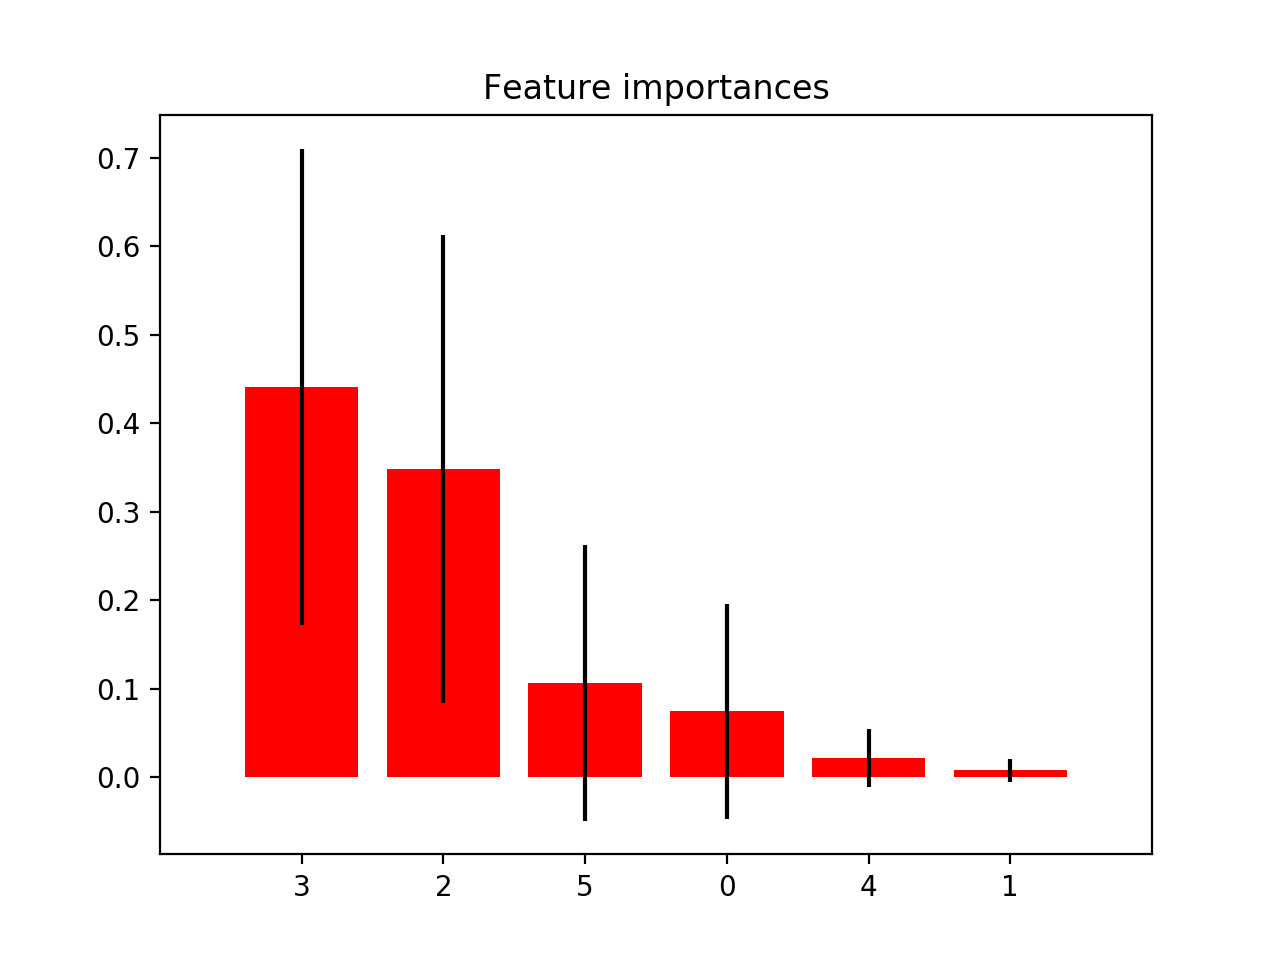

In [18]:
print("Column names: ", str(feature_names_books))

importances = rf_smote_train.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_smote_train.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Pritn features: 
X_sm
# Print the feature ranking
print("Feature ranking:")

for f in range(X_sm.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_sm.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_sm.shape[1]), indices)
plt.xlim([-1, X_sm.shape[1]])
plt.show()

### Hyperparameter tuning

In [63]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_smote_train.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


NameError: name 'make_scorer' is not defined

In [86]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(scoring = 'f1', estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_sm, y_sm)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='f1', verbose=2)

In [87]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [73]:
import sklearn.metrics

sorted(sklearn.metrics.SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

### Great. As we can see above, even though accuracy looks better on the model trained with real uninflated data, the models trained with inflated data get much better recall for the sold data. Precision still isn't that great though.

In [50]:
X = X_train1.to_numpy()
y = y_train1.to_numpy()

In [49]:
X_sm

array([[3.00000000e+00, 5.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.60000000e+02, 0.00000000e+00],
       [4.00000000e+00, 6.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.93000000e+02, 0.00000000e+00],
       [3.00000000e+00, 9.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.14000000e+02, 0.00000000e+00],
       ...,
       [2.39034800e+00, 1.20000000e+01, 1.00000000e+00, 1.00000000e+00,
        5.79144780e+01, 0.00000000e+00],
       [3.02105600e+00, 3.49789440e+01, 1.00000000e+00, 2.10559981e-02,
        2.50000000e+02, 1.00000000e+00],
       [3.00000000e+00, 6.59820376e+00, 1.00000000e+00, 1.00000000e+00,
        6.30000000e+01, 0.00000000e+00]])

Automatically created module for IPython interactive environment


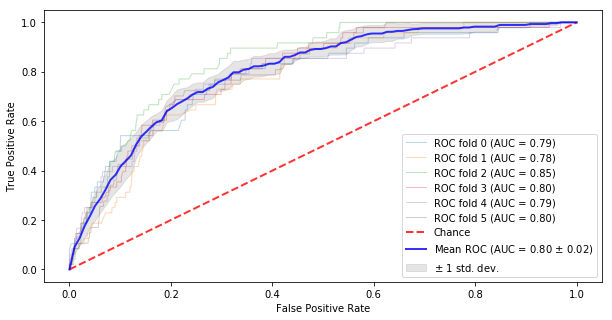

In [52]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis
# X = X_train1
# y = y_train1
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = RandomForestClassifier(max_depth = 4, 
                                        min_samples_split = 10, 
                                        n_estimators = 100, 
                                        random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams['figure.figsize'] = [10, 5]
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

The ROC AUC curve above looks good because its with the SMOTE-inflated data. Going to rerun with X_books, y_books rather than X_sm, y_sm

In [84]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_smote_train, X_test_FINAL, y_test_FINAL, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest (with SMOTE): ", rf_cv_score.mean())

=== All AUC Scores ===
[0.81111468 0.72598779 0.74092515 0.80613556 0.60762411 0.84893617
 0.83776596 0.79397163 0.82269504 0.9       ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest (with SMOTE):  0.7895156094438104


In [81]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_smote_train, X_sm, y_sm, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest (with SMOTE): ", rf_cv_score.mean())

=== All AUC Scores ===
[0.90597509 0.96801522 0.95501661 0.95672042 0.96763391 0.96622507
 0.95798424 0.96733634 0.96096842 0.9626485 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest (with SMOTE):  0.9568523821753299


In [172]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_adasyn_train, X_ad, y_ad, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest (with ADASYN): ", rf_cv_score.mean())

=== All AUC Scores ===
[0.89480556 0.95804834 0.95498908 0.94513157 0.94308136 0.96235848
 0.95960324 0.93540795 0.94562755 0.96545863]


=== Mean AUC Score ===
Mean AUC Score - Random Forest (with ADASYN):  0.9464511755052678


Wow these AUC scores from cross validation look really good! I need to create an AUC plot to include! 
=== All AUC Scores ===
[0.92420226 0.99231339 0.9944249  0.99324231 0.99734874 0.98448045
 0.98617653 0.99258983 0.99289677 0.95697637]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9814651543780906

### Visualizing our winning model (SMOTE + Random Forest) AUC scores


In [77]:
import matplotlib.pyplot as plt
import numpy

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = RandomForestClassifier(max_depth = 4, min_samples_split = 10, n_estimators = 100, random_state=0)
#classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)




%matplotlib inline
from scipy import interp

plt.rcParams['figure.figsize'] = [10, 5]


i = 0
for train, test in cv.split(X_sm, y_sm):
    probas_ = classifier.fit(X_sm[train], y_sm[train]).predict_proba(X_sm[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_sm[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with SMOTE')
plt.legend(loc="lower right")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'append'

## FIRST ATTEMPT AT RECALL-PRECISION CURVES

f1=0.132 auc=0.104 ap=0.109


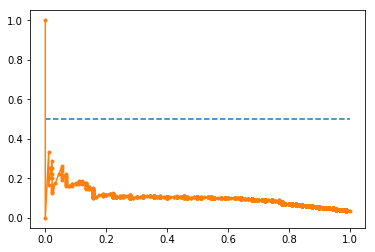

In [25]:
# from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# precision-recall curve and f1

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot


# predict probabilities
probs = rf_smote_train.predict_proba(X_test_FINAL)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = rf_smote_train.predict(X_test_FINAL)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_FINAL, probs)
# calculate F1 score
f1 = f1_score(y_test_FINAL, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test_FINAL, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

Automatically created module for IPython interactive environment


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.11')

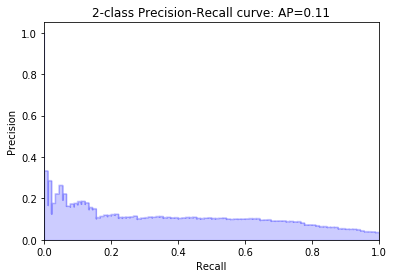

In [26]:
print(__doc__)
%matplotlib inline
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_score_rf = rf_smote_train.predict_proba(X_test_FINAL)[:,-1]

average_precision = average_precision_score(y_test_FINAL, y_score_rf)


precision, recall, _ = precision_recall_curve(y_test_FINAL, y_score_rf)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


In [18]:
print("Column names: ", str(feature_names_books))

Column names:  ['condition_ordinal', 'total_price', 'free_shipping', 'brand_included', 'description_length', 'topbrands']


Feature ranking:
1. feature 3 (0.271315)
2. feature 4 (0.203706)
3. feature 1 (0.202896)
4. feature 2 (0.177799)
5. feature 0 (0.111196)
6. feature 5 (0.033088)


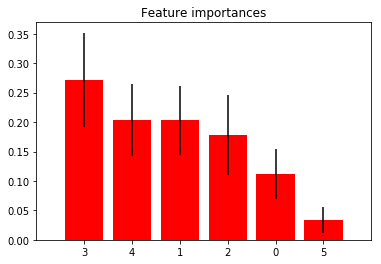

In [27]:
%matplotlib inline
importances = rf_smote_train.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_smote_train.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print features: 
X_train1
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train1.shape[1]), indices)
plt.xlim([-1, X_train1.shape[1]])
plt.show()



Strange. Free shipping and including a Brand are some of the most important features. Sklearns features importances has been criticized as being biased because it inflates the importance of continuous or high cardinality variables which isn't the case with either of these features.

Strange. Free shipping and including a Brand are some of the most important features.

## FINAL CHECKS

In [78]:
X_test.iloc[3,]

condition_ordinal       1.0
total_price            18.0
free_shipping           1.0
brand_included          0.0
description_length    250.0
Name: 240, dtype: float64

In [176]:
features = [[3,7,1,1,200]]
prediction = rf.predict(features)
print(prediction)

[1]


In [68]:
print('Accuracy of RF classifier on ORIGINAL subtest set: {:.4f}'
     .format(rf.score(X_test_FINAL, y_test_FINAL)))

rf_predicted = rf.predict(X_test_FINAL)
rf_confusion = confusion_matrix(y_test_FINAL, rf_predicted)

print('Random Forest \n', rf_confusion)

Accuracy of RF classifier on ORIGINAL subtest set: 0.9385
Random Forest 
 [[2753   90]
 [  91   10]]


## HOW TO SAVE MODEL FOR WEB APP

In [181]:
import pickle
pickle.dump(rf_smote_train, open('model.pkl', 'wb'))



 
# some time later...
# load the model from disk
#loaded_model = pickle.load(open('model.pkl', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Gradient-Boosted Decision Trees

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
gbdt.fit(X_un, y_un)
print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.4f}'
     .format(gbdt.score(X_un, y_un)))
print('Accuracy of GBDT classifier on test set: {:.4f}'
     .format(gbdt.score(X_test_FINAL, y_test_FINAL)))

gbdt_predicted = gbdt.predict(X_test_FINAL)
gbdt_confusion = confusion_matrix(y_test_FINAL, gbdt_predicted)

print('Gradient-Boosted Decision Trees \n', gbdt_confusion)

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.7158
Accuracy of GBDT classifier on test set: 0.7095
Gradient-Boosted Decision Trees 
 [[2014  822]
 [  28   62]]


## Evaluating these metrics with alternative models

In [40]:
from sklearn.metrics import classification_report

print('Dummy predictor (most frequent) \n', classification_report(y_test_FINAL, dummy_stratified_predicted, target_names=['available', 'sold']))
print('KNN \n', classification_report(y_test_FINAL, knn_predicted, target_names=['available', 'sold']))
print('Logistic regression\n', classification_report(y_test_FINAL, logreg_predicted, target_names = ['available', 'sold']))
print('SVC\n', classification_report(y_test_FINAL, svc_predicted, target_names = ['available', 'sold']))
print('Naive Bayes\n', classification_report(y_test_FINAL, nb_predicted, target_names = ['available', 'sold']))
print('Random Forest\n', classification_report(y_test_FINAL, rf_S_predicted, target_names = ['available', 'sold']))
print('Gradient-Boosted Decision Trees\n', classification_report(y_test_FINAL, gbdt_predicted, target_names = ['available', 'sold']))

Dummy predictor (most frequent) 
               precision    recall  f1-score   support

   available       0.96      0.50      0.66      2836
        sold       0.03      0.41      0.05        90

   micro avg       0.49      0.49      0.49      2926
   macro avg       0.49      0.45      0.35      2926
weighted avg       0.93      0.49      0.64      2926

KNN 
               precision    recall  f1-score   support

   available       0.98      0.58      0.73      2836
        sold       0.04      0.58      0.08        90

   micro avg       0.58      0.58      0.58      2926
   macro avg       0.51      0.58      0.40      2926
weighted avg       0.95      0.58      0.71      2926

Logistic regression
               precision    recall  f1-score   support

   available       0.99      0.73      0.84      2836
        sold       0.08      0.71      0.14        90

   micro avg       0.73      0.73      0.73      2926
   macro avg       0.53      0.72      0.49      2926
weighted avg 

In [37]:
print('Accuracy of dummy classifier on ORIGINAL subtest set: {:.4f}'
     .format(dummy_majority.score(X_un, y_un)))

dummy_majority_predicted = dummy_majority.predict(X_un)
dummy_majority_confusion = confusion_matrix(y_test_FINAL, dummy_majority_predicted)

print('Dummy Majority \n', dummy_majority_confusion)

NameError: name 'dummy_majority' is not defined

### KNN

I don't think it's reliable to use KNN and SMOTE simultaneously because SMOT may use the KNN method to upsample

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_un, y_un)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_un, y_un)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test_FINAL, y_test_FINAL)))

knn_predicted = knn.predict(X_test_FINAL)
knn_confusion = confusion_matrix(y_test_FINAL, knn_predicted)

print('KNN\n', knn_confusion)

Accuracy of K-NN classifier on training set: 0.7414
Accuracy of K-NN classifier on test set: 0.5766
KNN
 [[1635 1201]
 [  38   52]]


### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'lbfgs').fit(X_un, y_un)

print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_un, y_un)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test_FINAL, y_test_FINAL)))

logreg_predicted = logreg.predict(X_test_FINAL)
logreg_confusion = confusion_matrix(y_test_FINAL, logreg_predicted)

print('Logistic Regression\n', logreg_confusion)

Accuracy of Logistic regression classifier on training set: 0.7243
Accuracy of Logistic regression classifier on test set: 0.7252
Logistic Regression
 [[2058  778]
 [  26   64]]


/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Ridge Regression with Feature Normalization

In [35]:
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))



ridge regression linear model intercept: 0.311721747825589
ridge regression linear model coeff:
[0.02179547 0.6513468  0.16073864 0.02921111 0.08021726]
R-squared score (training): 0.033
R-squared score (test): 0.041
Number of non-zero features: 5


### SVC

In [33]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X_un, y_un)
print('Accuracy of Linear SVC classifier on training set: {:.4f}'
     .format(svc.score(X_un, y_un)))
print('Accuracy of Linear SVC classifier on test set: {:.4f}'
     .format(svc.score(X_test_FINAL, y_test_FINAL)))

svc_predicted = svc.predict(X_test_FINAL)
svc_confusion = confusion_matrix(y_test_FINAL, svc_predicted)

print('SVC \n', svc_confusion)

Accuracy of Linear SVC classifier on training set: 0.7003
Accuracy of Linear SVC classifier on test set: 0.8154
SVC 
 [[2332  504]
 [  36   54]]


/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_un, y_un)
print('Accuracy of GaussianNB classifier on training set: {:.4f}'
     .format(nb.score(X_un, y_un)))
print('Accuracy of GaussianNB classifier on test set: {:.4f}'
     .format(nb.score(X_test_FINAL, y_test_FINAL)))

nb_predicted = nb.predict(X_test_FINAL)
nb_confusion = confusion_matrix(y_test_FINAL, nb_predicted)

print('Naive Bayes \n', nb_confusion)

Accuracy of GaussianNB classifier on training set: 0.7295
Accuracy of GaussianNB classifier on test set: 0.7587
Naive Bayes 
 [[2154  682]
 [  24   66]]


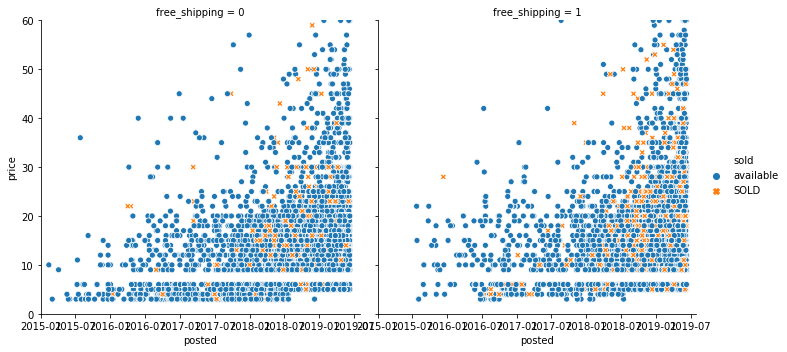

In [11]:

#Total price against date color coded by sold or for sale
# There seem to be a higher proporiton of free shipping purchases to non free shipping purchases in the sold graph!
%matplotlib inline
import seaborn as sns
book_plot = sns.relplot(x="posted", y="price", col="free_shipping", hue = "sold", style="sold", data=books)
book_plot.set(xlim=(datetime.date(2015, 1, 1), datetime.date(2019, 8, 1)), ylim=(0,60))
book_plot

In [148]:
print(X_test_FINAL)

       condition_ordinal  total_price  free_shipping  brand_included  \
2625                   1        11.00              1               0   
10063                  2         7.00              0               0   
34666                  3        13.25              0               1   
44631                  3        10.00              1               1   
28997                  3        15.90              0               0   
1302                   1        16.50              0               1   
13072                  2        15.50              0               0   
44661                  3        15.00              1               1   
266                    1        26.50              0               0   
28987                  3         9.00              0               0   
24153                  3         7.00              0               0   
906                    1        18.00              0               0   
10634                  2        15.00              1            